In [42]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import pickle

from typing import Counter

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

#### Import the entire dataset

In [2]:
all_bike_data = pd.read_csv('database.csv')
all_bike_data

/var/folders/2m/mbtxd4jx3lx7nvyzzz1ddqjw0000gp/T/ipykernel_3248/1100628121.py:1: DtypeWarning: Columns (2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  all_bike_data = pd.read_csv('database.csv')


,departure,return,departure_id,departure_name,return_id,return_name,distance (m),duration (sec.),avg_speed (km/h),departure_latitude,departure_longitude,return_latitude,return_longitude,Air temperature (degC)
0,2020-03-23 06:09:44,2020-03-23 06:16:26,86,Kuusitie,111.0,Esterinportti,1747.0,401.0,0.261397,60.195245,24.901900,60.197572,24.926781,0.9
1,2020-03-23 06:11:58,2020-03-23 06:26:31,26,Kamppi (M),10.0,Kasarmitori,1447.0,869.0,0.099908,60.168610,24.930537,60.165017,24.949473,0.9
2,2020-03-23 06:16:29,2020-03-23 06:24:23,268,Porolahden koulu,254.0,Agnetankuja,1772.0,469.0,0.226695,60.195540,25.053581,60.187234,25.036412,0.9
3,2020-03-23 06:33:53,2020-03-23 07:14:03,751,Vallipolku,106.0,Korppaanmäentie,7456.0,2406.0,0.185935,60.227827,24.819614,60.203474,24.898930,0.9
4,2020-03-23 06:36:09,2020-03-23 07:04:10,62,Länsisatamankatu,121.0,Vilhonvuorenkatu,7120.0,1679.0,0.254437,60.158928,24.909692,60.186463,24.967872,0.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12157453,2017-10-30 23:43:00,2017-10-30 23:55:00,64.0,Tyynenmerenkatu,64.0,Tyynenmerenkatu,918.0,714.0,0.077143,60.156838,24.920661,60.156838,24.920661,0.4
12157454,2017-10-30 23:49:00,2017-10-31 04:49:00,117.0,Brahen puistikko,44.0,Sörnäinen (M),822.0,252.0,0.195714,60.189671,24.948102,60.187736,24.960980,0.4
12157455,2017-10-30 23:52:00,2017-10-31 00:02:00,142.0,Koskelantie,141.0,Intiankatu,1817.0,594.0,0.183535,60.208749,24.946514,60.207858,24.967638,0.4
12157456,2017-10-30 23:57:00,2017-10-31 00:00:00,28.0,Lastenlehto,26.0,Kamppi (M),416.0,152.0,0.164211,60.165812,24.927021,60.168610,24.930537,0.4


##### Grab first 5000 rows for plotting

In [3]:
first_5000_ride = all_bike_data.head(5000)

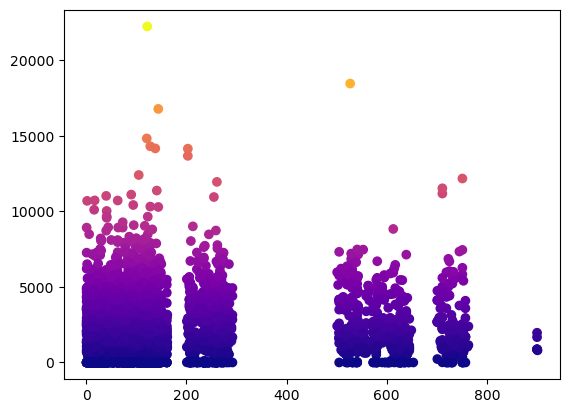

In [4]:
# Scatter plot first 5000 rows

plt.scatter(first_5000_ride['departure_id'], first_5000_ride['distance (m)'], c=first_5000_ride['distance (m)'], cmap=plt.cm.plasma)  # type: ignore
plt.show()

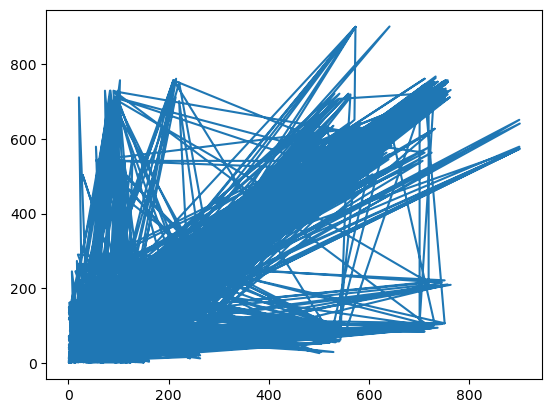

In [5]:
# Line plot first 5000 rows

plt.plot(first_5000_ride['departure_id'], first_5000_ride['return_id'])  # type: ignore
plt.show()

##### Average distance and speed

In [6]:
# Average distance of a bike ride
print("Average Distance: ", np.mean( all_bike_data['distance (m)']))

# Average speed of a bike ride
print("Average Speed: ", np.mean(all_bike_data['avg_speed (km/h)']) * 60) # multiple by 60 to get the answer in kms

Average Distance:  2295.275046986795
Average Speed:  20.133335930948522


#### Data Cleanup

In [7]:
# Check for NaN values in each column
columns_with_nan = all_bike_data.isna().any()

# Filter the column names with NaN values
columns_with_nan = columns_with_nan[columns_with_nan].index.tolist()

print("Columns with NaN values:", columns_with_nan)

Columns with NaN values: ['avg_speed (km/h)', 'return_latitude', 'return_longitude', 'Air temperature (degC)']


In [8]:
# Drop all rows that contain NAN values
# all_bike_data = all_bike_data.dropna()

all_bike_data = all_bike_data.fillna(0)

In [9]:
# Check for NaN values in each column
columns_with_nan = all_bike_data.isna().any()

# Filter the column names with NaN values
columns_with_nan = columns_with_nan[columns_with_nan].index.tolist()

print("Columns with NaN values:", columns_with_nan)

Columns with NaN values: []


In [10]:
# clean_and_tokenize removes any symbols, digits and makes all text lowercase
def clean_and_tokenize(text):
    cleaned_text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = cleaned_text.lower()
    return tokens

# Clean and tokenize the text in each column
all_bike_data['departure_name'] = all_bike_data['departure_name'].apply(clean_and_tokenize)
all_bike_data['return_name'] = all_bike_data['return_name'].apply(clean_and_tokenize)

In [11]:
# replace_letters_with_numbers removes the any beginning text from numerical data and replaces it with other numbers
# For example, 'A0' will turn into 1000, 'B0' will turn into 1002
def replace_letters_with_numbers(column):
    def replace_func(value):
        if isinstance(value, str):
            # Use regular expression to check if value starts with a letter followed by digits
            match = re.match(r'^([a-zA-Z])(\d+)$', value)
            if match:
                letter = match.group(1).upper()
                number = ((ord(letter) - ord('A')) * 2) + 1000
                return str(number) + match.group(2)
        return value

    return column.apply(replace_func)

# Turn the mixed columns into string ones
departure_id_column = all_bike_data['departure_id'].astype(str)
return_id_column = all_bike_data['return_id'].astype(str)

# Apply the function on the string columns
new_departure_id_column = replace_letters_with_numbers(departure_id_column)
new_return_id_column = replace_letters_with_numbers(return_id_column)

# Turn them back into numerical values
new_departure_id_column_numeric = pd.to_numeric(new_departure_id_column, errors='coerce')
new_return_id_column_numeric = pd.to_numeric(new_return_id_column, errors='coerce')

# Replace the old columns with new ones
all_bike_data['departure_id'] = new_departure_id_column_numeric
all_bike_data['return_id'] = new_return_id_column_numeric

In [41]:
# Check if the column has any text values
has_text1 = new_departure_id_column_numeric.apply(lambda x: isinstance(x, str)).any()
has_text2 = new_return_id_column_numeric.apply(lambda x: isinstance(x, str)).any()

# Count the number of rows with text
num_rows_with_text1 = all_bike_data['departure_id'].apply(lambda x: isinstance(x, str)).sum()
num_rows_with_text2 = all_bike_data['return_id'].apply(lambda x: isinstance(x, str)).sum()

print(num_rows_with_text1)
print(num_rows_with_text2)

0
0


##### Feature Engineering for the Date Columns

In [13]:
# Convert the date columns to datetime types
all_bike_data['departure'] = pd.to_datetime(all_bike_data['departure'])
all_bike_data['return'] = pd.to_datetime(all_bike_data['return'])

# Extract features from the departure column
all_bike_data['departure_year'] = all_bike_data['departure'].dt.year
all_bike_data['departure_month'] = all_bike_data['departure'].dt.month
all_bike_data['departure_day_of_week'] = all_bike_data['departure'].dt.dayofweek

# Extract features from the departure column
all_bike_data['return_year'] = all_bike_data['return'].dt.year
all_bike_data['return_month'] = all_bike_data['return'].dt.month
all_bike_data['return_day_of_week'] = all_bike_data['return'].dt.dayofweek

# Drop the original departure and return columns
all_bike_data = all_bike_data.drop(columns=['departure'])
all_bike_data = all_bike_data.drop(columns=['return'])
all_bike_data

,departure_id,departure_name,return_id,return_name,distance (m),duration (sec.),avg_speed (km/h),departure_latitude,departure_longitude,return_latitude,return_longitude,Air temperature (degC),departure_year,departure_month,departure_day_of_week,return_year,return_month,return_day_of_week
0,86.0,kuusitie,111.0,esterinportti,1747.0,401.0,0.261397,60.195245,24.901900,60.197572,24.926781,0.9,2020,3,0,2020,3,0
1,26.0,kamppi m,10.0,kasarmitori,1447.0,869.0,0.099908,60.168610,24.930537,60.165017,24.949473,0.9,2020,3,0,2020,3,0
2,268.0,porolahden koulu,254.0,agnetankuja,1772.0,469.0,0.226695,60.195540,25.053581,60.187234,25.036412,0.9,2020,3,0,2020,3,0
3,751.0,vallipolku,106.0,korppaanmentie,7456.0,2406.0,0.185935,60.227827,24.819614,60.203474,24.898930,0.9,2020,3,0,2020,3,0
4,62.0,lnsisatamankatu,121.0,vilhonvuorenkatu,7120.0,1679.0,0.254437,60.158928,24.909692,60.186463,24.967872,0.9,2020,3,0,2020,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12157453,64.0,tyynenmerenkatu,64.0,tyynenmerenkatu,918.0,714.0,0.077143,60.156838,24.920661,60.156838,24.920661,0.4,2017,10,0,2017,10,0
12157454,117.0,brahen puistikko,44.0,srninen m,822.0,252.0,0.195714,60.189671,24.948102,60.187736,24.960980,0.4,2017,10,0,2017,10,1
12157455,142.0,koskelantie,141.0,intiankatu,1817.0,594.0,0.183535,60.208749,24.946514,60.207858,24.967638,0.4,2017,10,0,2017,10,1
12157456,28.0,lastenlehto,26.0,kamppi m,416.0,152.0,0.164211,60.165812,24.927021,60.168610,24.930537,0.4,2017,10,0,2017,10,1


#### Defining an Anomaly

In [14]:
def is_anomaly(row):

    # If true, then anomaly exists and return 1, else return 0

    if ((row['distance (m)'] == 0) & (row['duration (sec.)'] > 0)
        or (row['avg_speed (km/h)'] > 25/60)
        or (row['avg_speed (km/h)'] > 0) & (row['avg_speed (km/h)'] < 2/60)
        or ((row['departure_id'] == row['return_id']) & (row['distance (m)'] > 600))):
        return 1
    else:
        return 0

##### Applying the anomaly function to the dataset

In [15]:
# Define a new column called 'anomaly' in the dataset, consisting of 0s and 1s
# 0 for a non-anomalous ride, and 1 for an anomalous one

all_bike_data['anomaly'] = all_bike_data.apply(is_anomaly, axis=1)

all_bike_data

,departure_id,departure_name,return_id,return_name,distance (m),duration (sec.),avg_speed (km/h),departure_latitude,departure_longitude,return_latitude,return_longitude,Air temperature (degC),departure_year,departure_month,departure_day_of_week,return_year,return_month,return_day_of_week,anomaly
0,86.0,kuusitie,111.0,esterinportti,1747.0,401.0,0.261397,60.195245,24.901900,60.197572,24.926781,0.9,2020,3,0,2020,3,0,0
1,26.0,kamppi m,10.0,kasarmitori,1447.0,869.0,0.099908,60.168610,24.930537,60.165017,24.949473,0.9,2020,3,0,2020,3,0,0
2,268.0,porolahden koulu,254.0,agnetankuja,1772.0,469.0,0.226695,60.195540,25.053581,60.187234,25.036412,0.9,2020,3,0,2020,3,0,0
3,751.0,vallipolku,106.0,korppaanmentie,7456.0,2406.0,0.185935,60.227827,24.819614,60.203474,24.898930,0.9,2020,3,0,2020,3,0,0
4,62.0,lnsisatamankatu,121.0,vilhonvuorenkatu,7120.0,1679.0,0.254437,60.158928,24.909692,60.186463,24.967872,0.9,2020,3,0,2020,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12157453,64.0,tyynenmerenkatu,64.0,tyynenmerenkatu,918.0,714.0,0.077143,60.156838,24.920661,60.156838,24.920661,0.4,2017,10,0,2017,10,0,1
12157454,117.0,brahen puistikko,44.0,srninen m,822.0,252.0,0.195714,60.189671,24.948102,60.187736,24.960980,0.4,2017,10,0,2017,10,1,0
12157455,142.0,koskelantie,141.0,intiankatu,1817.0,594.0,0.183535,60.208749,24.946514,60.207858,24.967638,0.4,2017,10,0,2017,10,1,0
12157456,28.0,lastenlehto,26.0,kamppi m,416.0,152.0,0.164211,60.165812,24.927021,60.168610,24.930537,0.4,2017,10,0,2017,10,1,0


In [16]:
anomaly_counts = Counter(all_bike_data['anomaly'])

# Count and print the number of anomalies in the dataset
# Before cleaning up data: 1024790

print(anomaly_counts[1])

1025648


##### Input/Output Split

In [17]:
# Split data into input and output
# X (input) contains the original columns, y (output) contains the anomaly column
X, y = all_bike_data.iloc[:, :-1], all_bike_data.iloc[:, -1]
print(X.shape, y.shape)

(12157458, 18) (12157458,)


##### Text Vectorization (Using the Count Vectorization Technique)

In [20]:
vectorizer_departure = CountVectorizer()
vectorizer_return = CountVectorizer()

# Vectorize the two columns separately
departure_name = vectorizer_departure.fit_transform(X['departure_name'])
return_name = vectorizer_return.fit_transform(X['return_name'])

# Transform columns into dataframes
df_departure_name = pd.DataFrame.sparse.from_spmatrix(departure_name, columns=vectorizer_departure.get_feature_names_out())
df_return_name = pd.DataFrame.sparse.from_spmatrix(return_name, columns=vectorizer_return.get_feature_names_out())

In [21]:
# Drop the non-vectorized columns and replace with vectorized ones
processed_data = pd.concat([X.drop(columns=['departure_name', 'return_name']), df_departure_name, df_return_name], axis=1)
processed_data

,departure_id,return_id,distance (m),duration (sec.),avg_speed (km/h),departure_latitude,departure_longitude,return_latitude,return_longitude,Air temperature (degC),...,viiskulma,vilhonvuorenkatu,virtasen,voikukantie,von,westendinasema,westendintie,wetterin,yhdyskunnankuja,ympyrtalo
0,86.0,111.0,1747.0,401.0,0.261397,60.195245,24.901900,60.197572,24.926781,0.9,...,0,0,0,0,0,0,0,0,0,0
1,26.0,10.0,1447.0,869.0,0.099908,60.168610,24.930537,60.165017,24.949473,0.9,...,0,0,0,0,0,0,0,0,0,0
2,268.0,254.0,1772.0,469.0,0.226695,60.195540,25.053581,60.187234,25.036412,0.9,...,0,0,0,0,0,0,0,0,0,0
3,751.0,106.0,7456.0,2406.0,0.185935,60.227827,24.819614,60.203474,24.898930,0.9,...,0,0,0,0,0,0,0,0,0,0
4,62.0,121.0,7120.0,1679.0,0.254437,60.158928,24.909692,60.186463,24.967872,0.9,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12157453,64.0,64.0,918.0,714.0,0.077143,60.156838,24.920661,60.156838,24.920661,0.4,...,0,0,0,0,0,0,0,0,0,0
12157454,117.0,44.0,822.0,252.0,0.195714,60.189671,24.948102,60.187736,24.960980,0.4,...,0,0,0,0,0,0,0,0,0,0
12157455,142.0,141.0,1817.0,594.0,0.183535,60.208749,24.946514,60.207858,24.967638,0.4,...,0,0,0,0,0,0,0,0,0,0
12157456,28.0,26.0,416.0,152.0,0.164211,60.165812,24.927021,60.168610,24.930537,0.4,...,0,0,0,0,0,0,0,0,0,0


In [22]:
processed_data.shape

(12157458, 767)

In [24]:
processed_data = processed_data.fillna(0)

#### Training, Testing and Evaluating Models

##### Train-Test Split

In [25]:
# Split data into train test sets
X_train, X_test, y_train, y_test = train_test_split(processed_data, y, test_size=0.33, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [27]:
# Check for NaN values in each column
columns_with_nan = processed_data.isna().any()

# Filter the column names with NaN values
columns_with_nan = columns_with_nan[columns_with_nan].index.tolist()

print("Columns with NaN values:", columns_with_nan)

Columns with NaN values: []


In [28]:
X_train = X_train.fillna(0)
y_train = y_train.fillna(0)

##### Decision Tree Model

In [29]:
# Initialize Decision Tree model
decision_tree_model = DecisionTreeClassifier()

# Fit the model on training data
decision_tree_model.fit(X_train, y_train)

# Make prediction on testing data
y_pred = decision_tree_model.predict(X_test)

/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [30]:
# Initialize SVC model
# model = SVC(kernel='linear', probability=True)  # Linear kernel for linear SVM

# Fit the model on training data
# model.fit(X_train, y_train)

##### Logistic Regression Model

In [31]:
# Initialize Logistic Regression model
# logistic_regression_model = LogisticRegression()

# Fit the model on training data
# logistic_regression_model.fit(X_train, y_train)

# Make prediction on testing data
# y_pred = logistic_regression_model.predict(X_test)

##### Testing the Model's Accuracy

In [32]:
# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

# Logistic Regression Model Accuracy:  0.920035384183599
# Decision Tree Model Accuracy:  0.9921228067464248

Accuracy:  0.9921681710843722


##### Saving the Model

In [37]:
# Save the Decision Tree model to disk
filename = 'final_helsinki_decision_tree_model.sav'
pickle.dump(decision_tree_model, open(filename, 'wb'))

##### Loading the Model

In [40]:
# Load the Decision Tree model from disk
loaded_decision_tree_model = pickle.load(open(filename, 'rb'))
result = loaded_decision_tree_model.score(X_test, y_test)
result

/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


0.9921681710843722

In [33]:
# Anomaly Research

# 1: (all_bike_data['distance (m)'] == 0) & (all_bike_data['duration (sec.)'] > 0) = 384184
# 2: ((all_bike_data['departure_latitude'] == all_bike_data['return_latitude']) & (all_bike_data['departure_longitude'] == all_bike_data['return_longitude'])) = 925669
# 3: (all_bike_data['departure_id'] == all_bike_data['return_id']) = 896162
# 4: (all_bike_data['avg_speed (km/h)'] > 25/60) = 18130
# 5: (all_bike_data['avg_speed (km/h)'] == 0) = 384184
# 6: (all_bike_data['avg_speed (km/h)'] > 0) & (all_bike_data['avg_speed (km/h)'] < 1/60) = 306796
# 7: ((all_bike_data['departure_id'] == all_bike_data['return_id']) & (all_bike_data['distance (m)'] > 1000)) = 175199
# 1 & 2 = 303584
# 2 & 3 = 896162

# anomaly_df = all_bike_data[((all_bike_data['departure_id'] == all_bike_data['return_id']) & (all_bike_data['distance (m)'] > 600))]
# anomaly_df